# Robomed

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook
from txt_feat import get_features
from sklearn.cluster import KMeans
from utils import get_disease_class
from lstm import KTokenizer, get_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

/home/s_belyaev/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Args

In [2]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [3]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [4]:
df = initial_pre(pd.read_csv(TRAIN_PATH))
len(df)

283086

In [5]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [6]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000


In [7]:
df.dtypes

diag_code    object
diag         object
age           int64
sex           int64
state        object
allergies    object
anamnesis    object
checkup      object
revisit       int64
dtype: object

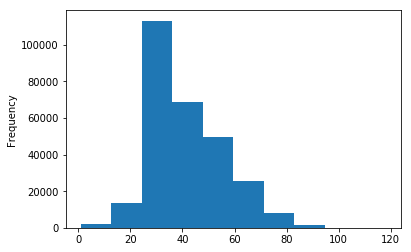

In [8]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Test analysis

### Look up

In [9]:
tdf = initial_pre(pd.read_csv(TEST_PATH))
tdf.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup
0,Z39.2,Рутинное послеродовое наблюдение,41,2,Общее самочувствие удовлетворительное. Кожные ...,Аллергию на лекарства - отрицает.,NaN,NaN
1,M54.2,Цервикалгия,64,2,NaN,не отягощен,NaN,NaN
2,M41,Сколиоз,34,2,"Удовлетворительное. Температура тела - 36,6. С...",NaN,NaN,NaN
3,J31.2,Хронический фарингит,58,2,NaN,NaN,NaN,Общее состояние удовлетворительное. Конфигурац...
4,M21.4,Плоская стопа [pes planus] (приобретенная),34,2,NaN,NaN,Жалобы сегодня с утра,NaN


In [10]:
tdf.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup
count,100000,100000,100000.000000,100000.000000,27475,36484,39282,10710
unique,2750,2718,NaN,NaN,2337,4790,31786,744
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.
freq,4618,4618,NaN,NaN,5807,15593,540,5382
mean,NaN,NaN,42.581630,1.663910,NaN,NaN,NaN,NaN
std,NaN,NaN,32.847483,0.472372,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,32.000000,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,39.000000,2.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN


In [11]:
df.sex.value_counts()

2    200523
1     82563
Name: sex, dtype: int64

In [12]:
tdf.sex.value_counts()

2    66391
1    33609
Name: sex, dtype: int64

### Not in `tdf`

In [13]:
def filter_not_in_test(df, tdf, column):
    df = df.copy()
    in_tdf = set(tdf.loc[:, column])
    return df[df.loc[:, column].isin(in_tdf)].copy()

In [14]:
for column in tqdm_notebook(df.columns):
    if column not in {'revisit', 'anamnesis'}:
        df = filter_not_in_test(df, tdf, column)
        print('after', column, df.shape)
df.shape

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

after diag_code (280470, 9)
after diag (280470, 9)
after age (280456, 9)
after sex (280456, 9)
after state (278242, 9)
after allergies (274857, 9)
after checkup (274572, 9)



(274572, 9)

### Strings fuzzy matching

In [15]:
def group_column(df, tdf, column):
    df, tdf = df.copy(), tdf.copy()
    columnv = pd.concat([df[column], tdf[column]])
    cvc = columnv.value_counts()
    bins = []
    for s, c in tqdm_notebook(cvc.iteritems()):
        max_id, max_score = None, None
        for id_, bin_ in enumerate(bins):
            cur_score = fuzz.ratio(s, bin_[0])
            if max_score is None or cur_score > max_score:
                max_id = id_
                max_score = cur_score
        if max_id is not None and max_score > 75:
            bins[max_id].append(s)
        else:
            bins.append([s])
    remap_dict = {}
    for bin_ in bins:
        base = bin_[0]
        for v in bin_:
            remap_dict[v] = base
    df[column] = df[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    tdf[column] = tdf[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    return df, tdf

In [16]:
# SIMILAR_TEXT_COLUMNS = ['state', 'allergies', 'checkup']
# for column in tqdm_notebook(SIMILAR_TEXT_COLUMNS):
#     df, tdf = group_column(df, tdf, column)
# df.shape, tdf.shape

## Preprocess

In [17]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode

In [18]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._tok = None
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df = df.copy()
    
        features = []
        
#         # diag_code
#         features.append(pd.DataFrame(list(df.diag_code.apply(parse_diag_code)), 
#                                      columns=['letter', 'code', 'subcode'],
#                                      dtype=object, index=df.index))
        # diag_code
        def to_str(x):
            if x is None:
                return ''
            else:
                return str(x)
        
        def pparse(x):
            l, c, s = x
            c = to_str(l) + to_str(c)
            if not c:
                c = None
            return (l, c)
        
        parts = list(df.diag_code \
                     .apply(parse_diag_code) \
                     .apply(pparse))
        features.append(pd.DataFrame(parts, 
                                     columns=['letter', 'code', 'subcode'][:2],
                                     dtype=object, index=df.index))
        
#         # +disease
#         features.append(pd.DataFrame(list(df.diag_code.apply(get_disease_class)),
#                                     columns=['disease'],
#                                     dtype=object, index=df.index))
        
#         # diag
#         features.append(df[['diag']])

        # age
        df.age = df.age.astype(float)
        df.loc[df.age > 120, 'age'] = np.nan
#         df.age = df.age.astype(str)  # => To cat
        features.append(df[['age']])

        # sex
        features.append(df[['sex']])

        # state
        def state_map(s):
            if 'удовлетворительн' in str(s).lower():
                return True
            else:
                return False
            
        features.append(pd.DataFrame(df.state.apply(state_map).astype(int),
                                     columns=['state'],
                                     index=df.index, dtype=int))
        
        # allergies, checkup
        features.append(df[['allergies', 'checkup']])
        
        
        # anamnesis
        features.append(get_features(df.anamnesis, df.index))
        features.append(pd.DataFrame(df.anamnesis.isnull().as_matrix().astype(int), 
                                     index=df.index, 
                                     columns=['anamnesis_null']))
#         def ana_map(a):
#             return len(a.split())
#             
#         features.append(pd.DataFrame(df.anamnesis.fillna('').apply(len).astype(float).as_matrix(),
#                                      columns=['anamnesis_len'],
#                                      index=df.index))
#         features.append(pd.DataFrame(df.anamnesis.fillna('').apply(ana_map).astype(float).as_matrix(),
#                                      columns=['anamnesis_cnt'],
#                                      index=df.index))
#         # anamnesis
#         if self._tok is None:
#             self._tok = KTokenizer().fit(df.anamnesis)
#         features.append(pd.DataFrame(get_score(self._tok.transform(df.anamnesis)).astype(np.float64),
#                                      columns=['lstm_score'],
#                                      index=df.index))

        data = pd.concat(features, axis=1)
        data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [19]:
ff = FFTransformer()
X, y = ff.fit_transform(df)
X.head()

,letter,code,diag,age,sex,state,allergies,checkup,count_nums,exclamation,larger_than_three,not_stop_words,number_words,punct,stop_words,string_len,anamnesis_null
0,J,J6,Острый ларингофарингит,29.0,2,0,NaN,На жевательной поверхности 2.6- кариозная поло...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,N,N76,Подострый и хронический вагинит,45.0,2,0,NaN,NaN,0.0,0.0,30.0,30.0,42.0,4.0,12.0,302.0,0
2,L,L23,"Аллергический контактный дерматит, причина не ...",63.0,2,0,NaN,NaN,1.0,0.0,10.0,11.0,14.0,5.0,3.0,99.0,0
3,N,N48,Баланопостит,43.0,2,0,не отягощен,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,Z,Z0,Общий медицинский осмотр,29.0,1,0,NaN,NaN,0.0,0.0,5.0,5.0,6.0,0.0,1.0,52.0,0


In [20]:
X.dtypes

letter                object
code                  object
diag                  object
age                  float64
sex                    int64
state                  int64
allergies             object
checkup               object
count_nums           float64
exclamation          float64
larger_than_three    float64
not_stop_words       float64
number_words         float64
punct                float64
stop_words           float64
string_len           float64
anamnesis_null         int64
dtype: object

In [21]:
y.dtype

dtype('int64')

## TT split

In [33]:
def downsampling(X, y):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    sampled_ids1 = y[y == 1].sample(len(ids0)).index
    nX = pd.concat([X.loc[ids0], X.loc[sampled_ids1]], axis=0)
    ny = pd.concat([y[ids0], y[sampled_ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny


def upsampling(X, y, max_cnt=10000):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    n = min(len(ids1), max_cnt)
    sampled_ids0 = y[y == 0].sample(n, replace=True).index
    index = np.arange(y.index.max() + 1, y.index.max() + n + 1)
    nX = X.loc[sampled_ids0]
    nX.index = index
    nX = pd.concat([nX, X.loc[ids1]], axis=0)
    ny = pd.concat([pd.Series(y[sampled_ids0].as_matrix(), index=index), y[ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny

In [34]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)
# X_train, y_train = upsampling(X_train, y_train)
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((260843, 17), (13729, 17), (100000, 17))

In [31]:
X.shape

(274572, 17)

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

### Run

In [135]:
N_MODELS = 5

In [136]:
models = [cb.CatBoostClassifier(depth=8, eval_metric='AUC', random_seed=42,
                                iterations=2000, od_type='Iter', od_wait=300) 
          for _ in range(N_MODELS)]

In [137]:
def get_stack_score(X):
    return np.vstack((model.predict_proba(X)[:, 1] for model in models)).mean(axis=0)


def get_f_im():
    return np.vstack((model.feature_importances_ for model in models)).mean(axis=0)

In [ ]:
for i, model in enumerate(models):
    print(f'ITERATION NUMBER {i}')
    X_train, X_val, y_train, y_val = train_test_split(*downsampling(X, y), test_size=0.1)
    model.fit(X_train, y_train, cat_features=cat_features, 
              use_best_model=True, eval_set=(X_val, y_val), 
              plot=False);

ITERATION NUMBER 0
0:	learn: 0.6949220	test: 0.6907328	best: 0.6907328 (0)	total: 128ms	remaining: 4m 16s
1:	learn: 0.6959803	test: 0.6932384	best: 0.6932384 (1)	total: 267ms	remaining: 4m 26s
2:	learn: 0.6960782	test: 0.6932277	best: 0.6932384 (1)	total: 439ms	remaining: 4m 52s
3:	learn: 0.6963068	test: 0.6933963	best: 0.6933963 (3)	total: 630ms	remaining: 5m 14s
4:	learn: 0.6967295	test: 0.6938945	best: 0.6938945 (4)	total: 849ms	remaining: 5m 38s
5:	learn: 0.6967018	test: 0.6941967	best: 0.6941967 (5)	total: 986ms	remaining: 5m 27s
6:	learn: 0.6967712	test: 0.6943852	best: 0.6943852 (6)	total: 1.09s	remaining: 5m 10s
7:	learn: 0.6966322	test: 0.6942890	best: 0.6943852 (6)	total: 1.19s	remaining: 4m 57s
8:	learn: 0.6995585	test: 0.6973980	best: 0.6973980 (8)	total: 1.34s	remaining: 4m 55s
9:	learn: 0.7022605	test: 0.7003054	best: 0.7003054 (9)	total: 1.51s	remaining: 5m 1s
10:	learn: 0.7032214	test: 0.7014167	best: 0.7014167 (10)	total: 1.72s	remaining: 5m 11s
11:	learn: 0.7044039	te

93:	learn: 0.7189563	test: 0.7165352	best: 0.7165730 (92)	total: 14.7s	remaining: 4m 57s
94:	learn: 0.7190297	test: 0.7165814	best: 0.7165814 (94)	total: 14.8s	remaining: 4m 57s
95:	learn: 0.7191092	test: 0.7165917	best: 0.7165917 (95)	total: 15s	remaining: 4m 56s
96:	learn: 0.7192904	test: 0.7167088	best: 0.7167088 (96)	total: 15.1s	remaining: 4m 56s
97:	learn: 0.7193876	test: 0.7167251	best: 0.7167251 (97)	total: 15.3s	remaining: 4m 56s
98:	learn: 0.7194360	test: 0.7167796	best: 0.7167796 (98)	total: 15.5s	remaining: 4m 56s
99:	learn: 0.7195032	test: 0.7168177	best: 0.7168177 (99)	total: 15.7s	remaining: 4m 57s
100:	learn: 0.7196160	test: 0.7169016	best: 0.7169016 (100)	total: 15.8s	remaining: 4m 57s
101:	learn: 0.7196599	test: 0.7169430	best: 0.7169430 (101)	total: 16s	remaining: 4m 56s
102:	learn: 0.7197706	test: 0.7169271	best: 0.7169430 (101)	total: 16.1s	remaining: 4m 55s
103:	learn: 0.7200082	test: 0.7170391	best: 0.7170391 (103)	total: 16.2s	remaining: 4m 54s
104:	learn: 0.720

184:	learn: 0.7267506	test: 0.7183775	best: 0.7183775 (184)	total: 29.7s	remaining: 4m 51s
185:	learn: 0.7268133	test: 0.7183662	best: 0.7183775 (184)	total: 29.8s	remaining: 4m 50s
186:	learn: 0.7268910	test: 0.7183238	best: 0.7183775 (184)	total: 30s	remaining: 4m 50s
187:	learn: 0.7269444	test: 0.7183047	best: 0.7183775 (184)	total: 30.2s	remaining: 4m 50s
188:	learn: 0.7269831	test: 0.7183342	best: 0.7183775 (184)	total: 30.4s	remaining: 4m 51s
189:	learn: 0.7270297	test: 0.7183425	best: 0.7183775 (184)	total: 30.6s	remaining: 4m 51s
190:	learn: 0.7271151	test: 0.7183564	best: 0.7183775 (184)	total: 30.7s	remaining: 4m 50s
191:	learn: 0.7271976	test: 0.7183574	best: 0.7183775 (184)	total: 30.8s	remaining: 4m 50s
192:	learn: 0.7273095	test: 0.7184090	best: 0.7184090 (192)	total: 31s	remaining: 4m 50s
193:	learn: 0.7273555	test: 0.7183879	best: 0.7184090 (192)	total: 31.2s	remaining: 4m 50s
194:	learn: 0.7274531	test: 0.7184529	best: 0.7184529 (194)	total: 31.4s	remaining: 4m 50s
195

275:	learn: 0.7332145	test: 0.7189193	best: 0.7189193 (275)	total: 45.3s	remaining: 4m 42s
276:	learn: 0.7333101	test: 0.7189675	best: 0.7189675 (276)	total: 45.4s	remaining: 4m 42s
277:	learn: 0.7333500	test: 0.7189975	best: 0.7189975 (277)	total: 45.6s	remaining: 4m 42s
278:	learn: 0.7334620	test: 0.7189834	best: 0.7189975 (277)	total: 45.8s	remaining: 4m 42s
279:	learn: 0.7335213	test: 0.7189463	best: 0.7189975 (277)	total: 46s	remaining: 4m 42s
280:	learn: 0.7335929	test: 0.7189654	best: 0.7189975 (277)	total: 46.1s	remaining: 4m 42s
281:	learn: 0.7336370	test: 0.7189861	best: 0.7189975 (277)	total: 46.3s	remaining: 4m 41s
282:	learn: 0.7336543	test: 0.7189647	best: 0.7189975 (277)	total: 46.4s	remaining: 4m 41s
283:	learn: 0.7337280	test: 0.7189751	best: 0.7189975 (277)	total: 46.5s	remaining: 4m 41s
284:	learn: 0.7338136	test: 0.7189942	best: 0.7189975 (277)	total: 46.8s	remaining: 4m 41s
285:	learn: 0.7338656	test: 0.7189976	best: 0.7189976 (285)	total: 47s	remaining: 4m 41s
286

366:	learn: 0.7395968	test: 0.7190121	best: 0.7190751 (290)	total: 1m	remaining: 4m 30s
367:	learn: 0.7397408	test: 0.7189704	best: 0.7190751 (290)	total: 1m	remaining: 4m 29s
368:	learn: 0.7398364	test: 0.7189756	best: 0.7190751 (290)	total: 1m 1s	remaining: 4m 29s
369:	learn: 0.7399322	test: 0.7189496	best: 0.7190751 (290)	total: 1m 1s	remaining: 4m 29s
370:	learn: 0.7399735	test: 0.7189587	best: 0.7190751 (290)	total: 1m 1s	remaining: 4m 29s
371:	learn: 0.7400510	test: 0.7189042	best: 0.7190751 (290)	total: 1m 1s	remaining: 4m 29s
372:	learn: 0.7400837	test: 0.7189387	best: 0.7190751 (290)	total: 1m 1s	remaining: 4m 29s
373:	learn: 0.7401343	test: 0.7189023	best: 0.7190751 (290)	total: 1m 1s	remaining: 4m 29s
374:	learn: 0.7401921	test: 0.7189134	best: 0.7190751 (290)	total: 1m 2s	remaining: 4m 28s
375:	learn: 0.7402400	test: 0.7188996	best: 0.7190751 (290)	total: 1m 2s	remaining: 4m 28s
376:	learn: 0.7403191	test: 0.7188926	best: 0.7190751 (290)	total: 1m 2s	remaining: 4m 28s
377:	

456:	learn: 0.7461768	test: 0.7190966	best: 0.7192229 (446)	total: 1m 16s	remaining: 4m 17s
457:	learn: 0.7462671	test: 0.7190874	best: 0.7192229 (446)	total: 1m 16s	remaining: 4m 17s
458:	learn: 0.7463031	test: 0.7190846	best: 0.7192229 (446)	total: 1m 16s	remaining: 4m 17s
459:	learn: 0.7463353	test: 0.7190747	best: 0.7192229 (446)	total: 1m 16s	remaining: 4m 16s
460:	learn: 0.7463956	test: 0.7190891	best: 0.7192229 (446)	total: 1m 16s	remaining: 4m 16s
461:	learn: 0.7464967	test: 0.7190982	best: 0.7192229 (446)	total: 1m 17s	remaining: 4m 16s
462:	learn: 0.7465613	test: 0.7190837	best: 0.7192229 (446)	total: 1m 17s	remaining: 4m 16s
463:	learn: 0.7466442	test: 0.7190515	best: 0.7192229 (446)	total: 1m 17s	remaining: 4m 16s
464:	learn: 0.7467643	test: 0.7190385	best: 0.7192229 (446)	total: 1m 17s	remaining: 4m 16s
465:	learn: 0.7468541	test: 0.7189978	best: 0.7192229 (446)	total: 1m 17s	remaining: 4m 16s
466:	learn: 0.7468841	test: 0.7190022	best: 0.7192229 (446)	total: 1m 17s	remain

547:	learn: 0.7521571	test: 0.7191492	best: 0.7192269 (530)	total: 1m 31s	remaining: 4m 2s
548:	learn: 0.7522374	test: 0.7191784	best: 0.7192269 (530)	total: 1m 31s	remaining: 4m 2s
549:	learn: 0.7523182	test: 0.7191779	best: 0.7192269 (530)	total: 1m 31s	remaining: 4m 2s
550:	learn: 0.7524162	test: 0.7191619	best: 0.7192269 (530)	total: 1m 32s	remaining: 4m 2s
551:	learn: 0.7524848	test: 0.7191388	best: 0.7192269 (530)	total: 1m 32s	remaining: 4m 2s
552:	learn: 0.7526092	test: 0.7191429	best: 0.7192269 (530)	total: 1m 32s	remaining: 4m 2s
553:	learn: 0.7526551	test: 0.7191326	best: 0.7192269 (530)	total: 1m 32s	remaining: 4m 1s
554:	learn: 0.7527456	test: 0.7191186	best: 0.7192269 (530)	total: 1m 32s	remaining: 4m 1s
555:	learn: 0.7528249	test: 0.7190874	best: 0.7192269 (530)	total: 1m 32s	remaining: 4m 1s
556:	learn: 0.7528435	test: 0.7190858	best: 0.7192269 (530)	total: 1m 33s	remaining: 4m 1s
557:	learn: 0.7528864	test: 0.7190937	best: 0.7192269 (530)	total: 1m 33s	remaining: 4m 1s

In [39]:
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', 
#                               iterations=1000)
# model.fit(X, y, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_test, y_test), 
#           plot=False);

In [40]:
# pool = cb.Pool(X, y, cat_features=cat_features)
# params = {
#     'depth': 8, 
#     'eval_metric': 'AUC'
# }
# cb.cv(pool, params, seed=42)

In [50]:
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', rsm=.5)
# model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

### Analysis

In [123]:
# roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
roc_auc_score(y_val, get_stack_score(X_val))

0.7404067855509635

In [126]:
# confusion_matrix(y_val, model.predict(X_val))

In [44]:
model.get_params()

{'depth': 8, 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'rsm': 0.5}

In [45]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
    plt.show()

In [111]:
# draw_importance(X_train.columns, model.feature_importances_, save_path=None)

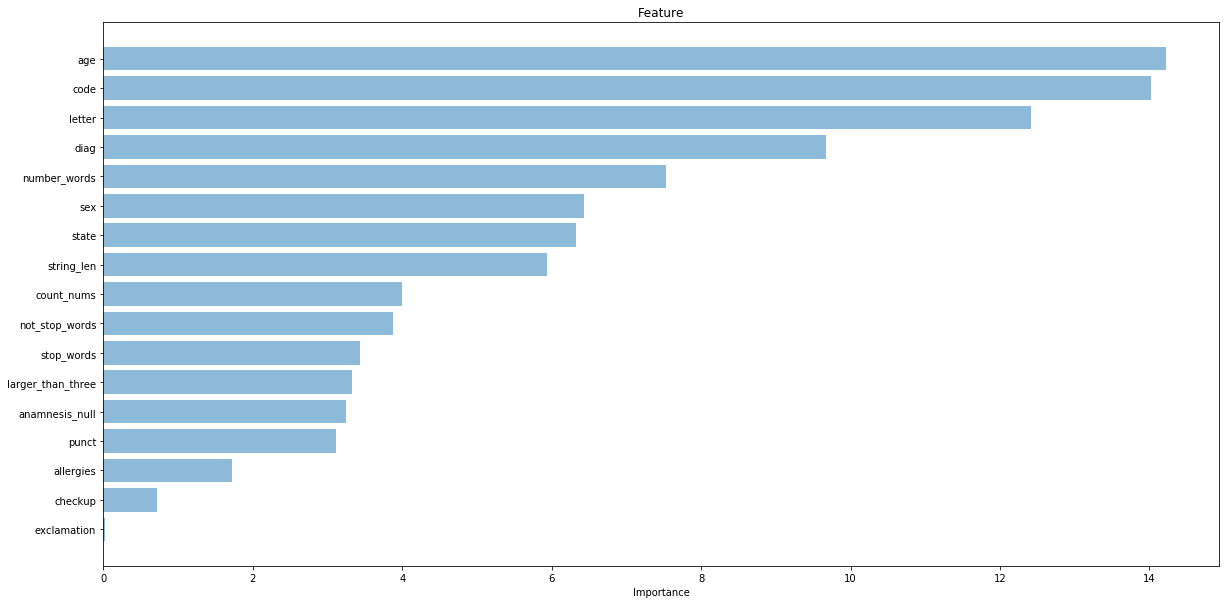

In [127]:
draw_importance(X_train.columns, get_f_im(), save_path=None)

## Submission

In [121]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = get_stack_score(X_test)
sdf.head()

,ID,proba
0,0,0.623298
1,1,0.602822
2,2,0.387293
3,3,0.820879
4,4,0.271759


In [48]:
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = model.predict_proba(X_test)[:, 1]
# sdf.head()

,ID,proba
0,0,0.891997
1,1,0.873455
2,2,0.751918
3,3,0.957088
4,4,0.657018


In [96]:
sdf.to_csv(SUBMISSION_PATH, index=False)

## LIGHTGBM

In [75]:
# import lightgbm as lgb

In [83]:
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [85]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': ['binary_logloss', 'auc'],
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=20,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=5)

In [ ]:
# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

## BT_ITER

In [ ]:
# N_ITERS = 2

In [ ]:
# y_prob1 = model.predict_proba(X_test)[:, 1]

In [ ]:
# np.where((y_prob1 >= .95) | (y_prob1 <= .05))[0].shape

In [ ]:
# y_prob1 = model.predict_proba(X_test)[:, 1]

In [ ]:
# np.where(y_prob1 <= .5)[0].shape

In [ ]:
# np.where(y_prob1 >= .95)[0].shape

In [ ]:
# y_prob1 = model.predict_proba(X_test)[:, 1]
# t0i = np.where(y_prob1 <= .05)[0]
# t1i = np.where(y_prob1 >= .95)[0]
# vtdf = tdf.copy()
# vtdf['revisit'] = np.zeros(len(vtdf)).astype(int)
# vtdf.loc[t1i, 'revisit'] = 1
# vtdf = vtdf.loc[t0i | t1i]
# vtdf.head()

In [ ]:
# confusion_matrix(y_val, model.predict(X_val))

In [ ]:
# (y_val == 0).sum() / len(y_val)

In [ ]:
# vdf = df.copy()

# # TT split
# preprocess = FFTransformer()
# X, y = preprocess.fit_transform(vdf)
# cat_features = np.where(X.dtypes != np.float)[0]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
# X_test = preprocess.transform(tdf)

# # Train
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', 
#                               iterations=1000)
# model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

# # BT
# y_prob1 = model.predict_proba(X_test)[:, 1]
# t0i = np.where(y_prob1 <= .05)[0]
# t1i = np.where(y_prob1 >= .95)[0]
# vtdf = tdf.copy()
# vtdf['revisit'] = np.zeros(len(vtdf)).astype(int)
# vtdf.loc[t1i, 'revisit'] = 1


# # Submission
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = y_prob1
# sdf.to_csv(SUBMISSION_PATH, index=False)

## TRAIN_ITER

In [ ]:
# from hyperdash import Experiment

In [ ]:
# best_score = None
# exp = Experiment('ITER PROCESS AIHACK 2018', capture_io=False)

# for i in range(100):
    
#     # TT split
#     preprocess = FFTransformer()
#     X, y = preprocess.fit_transform(df)
#     cat_features = np.where(X.dtypes != np.float)[0]
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)
#     X_test = preprocess.transform(tdf)
    
#     # CatBoost
#     model = cb.CatBoostClassifier(depth=8, eval_metric='AUC')
#     model.fit(X_train, y_train, cat_features=cat_features, 
#               use_best_model=True, eval_set=(X_val, y_val), 
#               plot=False);
    
#     # Analysis
#     score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    
#     exp.metric('step', i)
#     exp.metric('score', score)
    
#     # Submission
#     if best_score is None or score > best_score:
#         best_score = score
#         print(f'Saving model at step {i} with score {score}')
#         sdf = pd.DataFrame(tdf.index, columns=['ID'])
#         sdf['proba'] = model.predict_proba(X_test)[:, 1]
#         sdf.to_csv(SUBMISSION_PATH, index=False)

# exp.end()